# Preprocessing

## 1: Import & Load Data
Import library dan load metadata dari CSV.


In [4]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

# Path & parameter
TRAIN_DIR = "datasetaudio/train"

# Parameter preprocessing
TARGET_SR = 22050         # target sample rate
TARGET_DURATION = 1.0     # target durasi 1 detik
MAX_LEN = int(TARGET_SR * TARGET_DURATION)
TEST_SIZE = 0.2           # (tetap ada, meskipun tidak dipakai di cell ini)
RANDOM_STATE = 42         # reproducibility

# Pilihan file contoh: ambil speaker 'asep' kalau ada, action 'buka', index ke-2 (manusia) -> idx=1
PREFERRED_SPEAKER = "asep"
PREFERRED_ACTION = "buka"
TARGET_INDEX = 1   

Fungsi Preprocessing 


In [5]:
def preprocess_audio(file_path, target_sr=TARGET_SR, target_len=MAX_LEN, noise_reduction=True):
    """
    Membaca audio dan mengubah ke bentuk konsisten (sample rate, durasi, normalisasi)
    """
    # 1. Load audio (resample ke target_sr)
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # 2. Trim ke durasi tetap (potong / pad)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)), mode='constant')
    else:
        y = y[:target_len]
    
    # 3. Normalisasi amplitudo (skala -1 sampai 1)
    y = y / (np.max(np.abs(y)) + 1e-6)
    
    # 4. Hilangkan noise kecil (threshold sederhana)
    if noise_reduction:
        y[np.abs(y) < 0.005] = 0.0
    
    return y, sr

CONTOH SEBELUM DAN SESUDAH PREPROCESSING


Sample file            : datasetaudio/train/asep/buka/Buka10.wav
Speaker / Action       : asep / buka   (filename: Buka10.wav)
Sample rate asli       : 48000 Hz | Durasi asli: 2.26 s
Sample rate setelah pr : 22050 Hz | Durasi baru  : 1.00 s


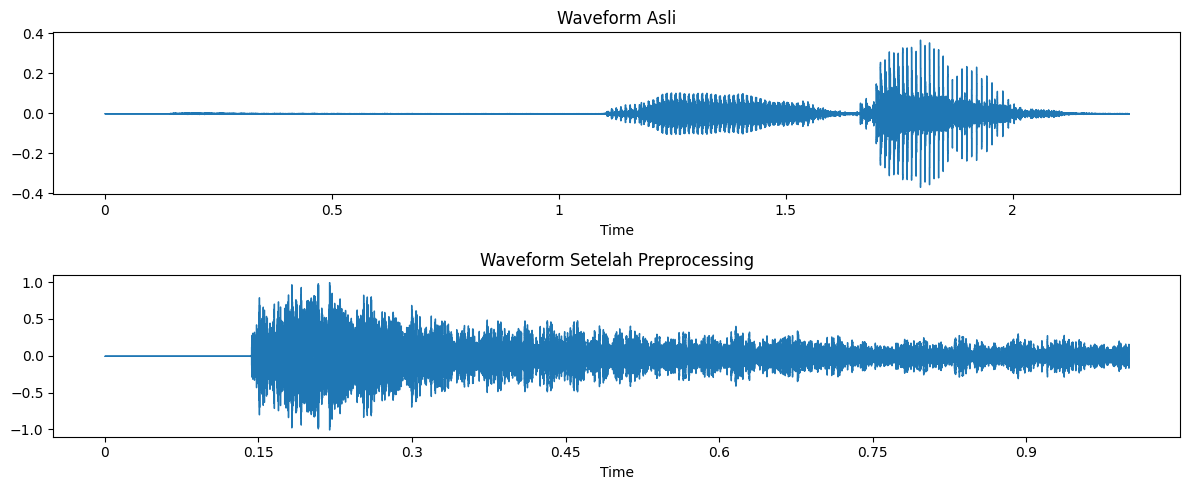

🔊 Sebelum preprocessing:


🔊 Setelah preprocessing:


In [6]:
def find_sample_file(train_dir, speaker_pref=PREFERRED_SPEAKER, action_pref=PREFERRED_ACTION, target_idx=TARGET_INDEX):
    # ambil speaker yang tersedia (deterministik: sorted)
    speakers = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    if len(speakers) == 0:
        raise FileNotFoundError(f"Tidak ada folder speaker di {train_dir}")
    
    # pilih speaker preferred jika ada, kalau tidak pakai speaker pertama
    speaker = speaker_pref if speaker_pref in speakers else speakers[0]
    speaker_path = os.path.join(train_dir, speaker)
    
    # ambil action yang tersedia di speaker (deterministik: sorted)
    actions = sorted([d for d in os.listdir(speaker_path) if os.path.isdir(os.path.join(speaker_path, d))])
    if len(actions) == 0:
        raise FileNotFoundError(f"Tidak ada subfolder (buka/tutup) di {speaker_path}")
    
    action = action_pref if action_pref in actions else actions[0]
    action_path = os.path.join(speaker_path, action)
    
    # ambil file audio yang valid
    valid_exts = (".wav", ".mp3", ".flac", ".ogg", ".m4a")
    files = sorted([f for f in os.listdir(action_path) if f.lower().endswith(valid_exts)])
    if len(files) == 0:
        raise FileNotFoundError(f"Tidak ada file audio di {action_path}")
    
    idx = target_idx if target_idx < len(files) else (len(files) - 1)
    return os.path.join(action_path, files[idx]), speaker, action, files[idx]

# ---------------------------------------
# Dapatkan sample file (asep/buka index ke-2 jika tersedia)
try:
    sample_file, spk, act, fname = find_sample_file(TRAIN_DIR)
except Exception as e:
    print("Gagal menemukan sample file:", e)
    sample_file = None

if sample_file:
    # load asli (tanpa resample) untuk perbandingan
    y_raw, sr_raw = librosa.load(sample_file, sr=None)
    # preprocess dengan fungsi kita (resampled ke TARGET_SR dan dipotong/pad jadi MAX_LEN)
    y_proc, sr_proc = preprocess_audio(sample_file)

    print(f"Sample file            : {sample_file}")
    print(f"Speaker / Action       : {spk} / {act}   (filename: {fname})")
    print(f"Sample rate asli       : {sr_raw} Hz | Durasi asli: {len(y_raw)/sr_raw:.2f} s")
    print(f"Sample rate setelah pr : {sr_proc} Hz | Durasi baru  : {len(y_proc)/sr_proc:.2f} s")

    # Plot waveform sebelum dan sesudah
    fig, ax = plt.subplots(2, 1, figsize=(12, 5))
    librosa.display.waveshow(y_raw, sr=sr_raw, ax=ax[0])
    ax[0].set_title("Waveform Asli")
    librosa.display.waveshow(y_proc, sr=sr_proc, ax=ax[1])
    ax[1].set_title("Waveform Setelah Preprocessing")
    plt.tight_layout()
    plt.show()

    # Putar audio sebelum dan sesudah
    print("🔊 Sebelum preprocessing:")
    display(ipd.Audio(y_raw, rate=sr_raw))
    print("🔊 Setelah preprocessing:")
    display(ipd.Audio(y_proc, rate=sr_proc))
else:
    print("Tidak ada sample file untuk ditampilkan.")

DATASET HASIL PREPROCESSING

In [8]:
import os
import tqdm
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split

def preprocess_dataset_with_split(base_path, test_size=0.2, random_state=42):
    """
    Membaca seluruh file audio dari struktur:
      base_path/
        speaker1/
          action1/
          action2/
        speaker2/
          action1/
          action2/
    Lalu preprocessing (memanggil preprocess_audio) dan split ke train/val.
    Mengembalikan list of tuples: (y, speaker, action, filename)
    """
    all_items = []   # akan berisi dict: {'y':..., 'speaker':..., 'action':..., 'combined':..., 'filename':...}
    
    valid_exts = (".wav", ".mp3", ".flac", ".ogg", ".m4a")
    # traverse speakers
    speakers = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    if not speakers:
        raise FileNotFoundError(f"Tidak ditemukan folder speaker di: {base_path}")
    
    for sp in speakers:
        sp_path = os.path.join(base_path, sp)
        actions = sorted([d for d in os.listdir(sp_path) if os.path.isdir(os.path.join(sp_path, d))])
        if not actions:
            print(f"Warning: speaker '{sp}' tidak punya subfolder action. Lewat.")
            continue
        
        for act in actions:
            act_path = os.path.join(sp_path, act)
            files = sorted([f for f in os.listdir(act_path) if f.lower().endswith(valid_exts)])
            print(f"Processing {len(files)} files for {sp}/{act} ...")
            for fn in tqdm.tqdm(files, desc=f"{sp}/{act}"):
                fp = os.path.join(act_path, fn)
                try:
                    y, sr = preprocess_audio(fp)   # gunakan fungsi preprocess_audio kamu
                    combined = f"{sp}_{act}"
                    all_items.append({
                        'y': y,
                        'speaker': sp,
                        'action': act,
                        'combined': combined,
                        'filename': fn
                    })
                except Exception as e:
                    print(f"  Gagal proses {fp}: {e}")
                    continue
    
    if len(all_items) == 0:
        raise RuntimeError("Tidak ada file audio yang berhasil diproses.")
    
    # Persiapkan X dan label untuk split (stratify berdasarkan combined label)
    X = [d['y'] for d in all_items]
    combined_labels = [d['combined'] for d in all_items]
    
    # Gunakan stratify pada combined_labels agar distribusi tiap kombinasi terjaga
    X_train, X_val, y_comb_train, y_comb_val, idx_train, idx_val = train_test_split(
        X, combined_labels, list(range(len(X))),
        test_size=test_size, random_state=random_state, stratify=combined_labels
    )
    
    # Build train/val datasets (kembalikan speaker/action/filename juga)
    train_data = []
    val_data = []
    # create mapping from index to original dict entry
    for i in idx_train:
        entry = all_items[i]
        train_data.append((entry['y'], entry['speaker'], entry['action'], entry['filename']))
    for i in idx_val:
        entry = all_items[i]
        val_data.append((entry['y'], entry['speaker'], entry['action'], entry['filename']))
    
    return train_data, val_data

# ---- Jalankan preprocessing + split ----
train_data, val_data = preprocess_dataset_with_split(TRAIN_DIR, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Simpan hasil preprocessing ke file
joblib.dump(train_data, "train_preprocessed.pkl")
joblib.dump(val_data, "val_preprocessed.pkl")

print(f"\n✅ Data berhasil di-split:")
print(f"   Training   : {len(train_data)} samples")
print(f"   Validation : {len(val_data)} samples")

# Cek distribusi kelas setelah split (speaker / action / combined)
train_speakers = [t[1] for t in train_data]
train_actions  = [t[2] for t in train_data]
train_combined = [f"{t[1]}_{t[2]}" for t in train_data]

val_speakers = [t[1] for t in val_data]
val_actions  = [t[2] for t in val_data]
val_combined = [f"{t[1]}_{t[2]}" for t in val_data]

print("\n📊 Distribusi setelah split (TRAIN):")
print("  Speakers :", dict(Counter(train_speakers)))
print("  Actions  :", dict(Counter(train_actions)))
print("  Combined :", dict(Counter(train_combined)))

print("\n📊 Distribusi setelah split (VAL):")
print("  Speakers :", dict(Counter(val_speakers)))
print("  Actions  :", dict(Counter(val_actions)))
print("  Combined :", dict(Counter(val_combined)))


Processing 50 files for asep/buka ...


asep/buka: 100%|██████████| 50/50 [00:00<00:00, 414.03it/s]


Processing 50 files for asep/tutup ...


asep/tutup: 100%|██████████| 50/50 [00:00<00:00, 425.63it/s]


Processing 50 files for yotan/buka ...


yotan/buka: 100%|██████████| 50/50 [00:00<00:00, 483.84it/s]


Processing 50 files for yotan/tutup ...


yotan/tutup: 100%|██████████| 50/50 [00:00<00:00, 654.87it/s]



✅ Data berhasil di-split:
   Training   : 160 samples
   Validation : 40 samples

📊 Distribusi setelah split (TRAIN):
  Speakers : {'asep': 80, 'yotan': 80}
  Actions  : {'tutup': 80, 'buka': 80}
  Combined : {'asep_tutup': 40, 'yotan_tutup': 40, 'asep_buka': 40, 'yotan_buka': 40}

📊 Distribusi setelah split (VAL):
  Speakers : {'asep': 20, 'yotan': 20}
  Actions  : {'buka': 20, 'tutup': 20}
  Combined : {'asep_buka': 10, 'yotan_buka': 10, 'asep_tutup': 10, 'yotan_tutup': 10}


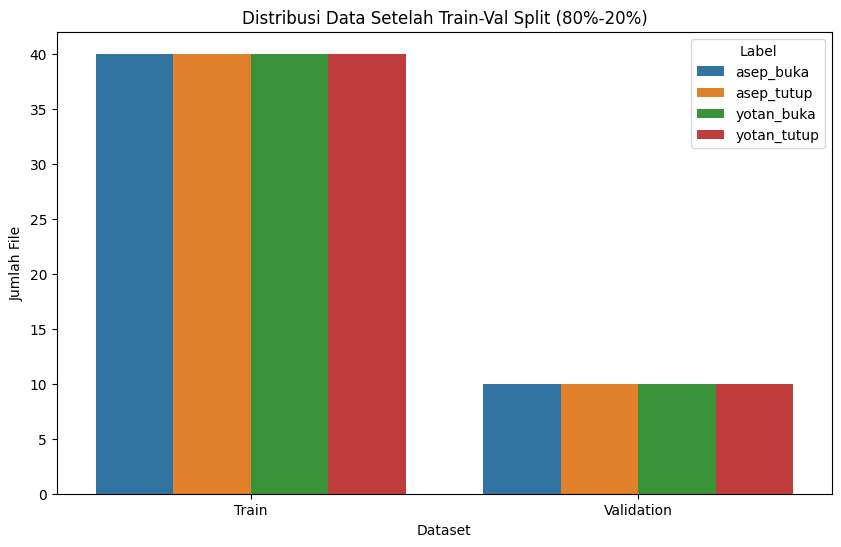


Proporsi split:
Training: 160/200 = 80.0%
Validation: 40/200 = 20.0%


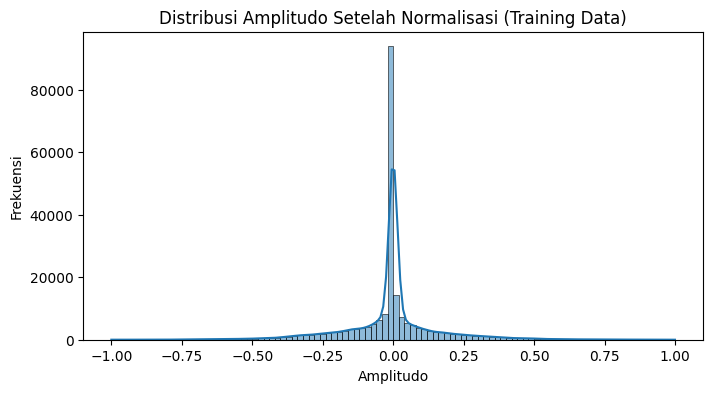

In [9]:
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Buat label baru (combined) dari train_data & val_data
train_labels = [f"{sp}_{act}" for _, sp, act, _ in train_data]
val_labels   = [f"{sp}_{act}" for _, sp, act, _ in val_data]

train_counter = Counter(train_labels)
val_counter   = Counter(val_labels)

# Siapkan dataframe untuk plot
split_data = []
all_labels = sorted(list(set(train_labels + val_labels)))

for label in all_labels:
    split_data.append({'Dataset': 'Train', 'Label': label, 'Jumlah': train_counter.get(label, 0)})
    split_data.append({'Dataset': 'Validation', 'Label': label, 'Jumlah': val_counter.get(label, 0)})

df_split = pd.DataFrame(split_data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_split, x='Dataset', y='Jumlah', hue='Label')
plt.title("Distribusi Data Setelah Train-Val Split (80%-20%)")
plt.ylabel("Jumlah File")
plt.show()

# --- Proporsi Split ---
print("\nProporsi split:")
total_train = sum(train_counter.values())
total_val   = sum(val_counter.values())
total_all   = total_train + total_val

print(f"Training: {total_train}/{total_all} = {total_train/total_all*100:.1f}%")
print(f"Validation: {total_val}/{total_all} = {total_val/total_all*100:.1f}%")

# --- Analisis distribusi amplitudo ---
samples = [y for (y, _, _, _) in train_data[:10]]   # ambil 10 contoh waveform
amps = np.concatenate(samples)

plt.figure(figsize=(8,4))
sns.histplot(amps, bins=100, kde=True)
plt.title("Distribusi Amplitudo Setelah Normalisasi (Training Data)")
plt.xlabel("Amplitudo")
plt.ylabel("Frekuensi")
plt.show()


Feature Extraction (Statistik Time Series) Suara Buka Tutup

Import dan load data

In [15]:
# Feature extraction adapted for datasetaudio/train/{speaker}/{action} format
import numpy as np
import pandas as pd
import librosa
import scipy.stats
import joblib
import tqdm
import json
import os

# load preprocessed data (format: (y, speaker, action, filename))
train_data = joblib.load("train_preprocessed.pkl")
val_data   = joblib.load("val_preprocessed.pkl")

print(f"Data berhasil dimuat. Total train: {len(train_data)}, val: {len(val_data)}")

Data berhasil dimuat. Total train: 160, val: 40


2. Fungsi Ekstraksi Fitur

In [16]:
def extract_comprehensive_features(y, sr=22050):
    feats = {}
    # ensure numpy array
    y = np.asarray(y, dtype=float)
    # BASIC STATISTICS
    feats['stat_mean'] = np.mean(y)
    feats['stat_std']  = np.std(y)
    feats['stat_var']  = np.var(y)
    feats['stat_skew'] = float(scipy.stats.skew(y)) if y.size > 2 else 0.0
    feats['stat_kurt'] = float(scipy.stats.kurtosis(y)) if y.size > 2 else 0.0
    feats['stat_min']  = np.min(y)
    feats['stat_max']  = np.max(y)
    feats['stat_range']= feats['stat_max'] - feats['stat_min']
    feats['stat_median']= np.median(y)
    feats['stat_q25']  = np.percentile(y, 25)
    feats['stat_q75']  = np.percentile(y, 75)
    feats['stat_iqr']  = feats['stat_q75'] - feats['stat_q25']

    # TEMPORAL FEATURES
    feats['temp_rms'] = float(np.sqrt(np.mean(y**2)))
    feats['temp_energy'] = float(np.sum(y**2))
    try:
        feats['temp_zcr'] = float(np.mean(librosa.feature.zero_crossing_rate(y)))
    except Exception:
        feats['temp_zcr'] = 0.0

    # Autocorrelation (partial)
    try:
        autocorr = np.correlate(y, y, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        feats['temp_autocorr_max'] = float(np.max(autocorr[1:100])) if autocorr.size>1 else 0.0
    except Exception:
        feats['temp_autocorr_max'] = 0.0

    # Peak analysis (on absolute waveform)
    try:
        peaks = librosa.util.peak_pick(np.abs(y), pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.02, wait=10)
        feats['temp_peak_count'] = int(len(peaks))
        feats['temp_peak_mean'] = float(np.mean(np.abs(y[peaks])) ) if len(peaks)>0 else 0.0
    except Exception:
        feats['temp_peak_count'] = 0
        feats['temp_peak_mean'] = 0.0

    # Onset detection
    try:
        onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
        feats['temp_onset_count'] = int(len(onset_frames))
        feats['temp_onset_rate'] = float(len(onset_frames) / (len(y) / sr)) if len(y)>0 else 0.0
    except Exception:
        feats['temp_onset_count'] = 0
        feats['temp_onset_rate'] = 0.0

    # SPECTRAL FEATURES (wrap each in try/except to be robust for short signals)
    try:
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        feats['spec_centroid_mean'] = float(np.mean(centroid))
        feats['spec_centroid_std']  = float(np.std(centroid))
    except Exception:
        feats['spec_centroid_mean'] = feats['spec_centroid_std'] = 0.0

    try:
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        feats['spec_bandwidth_mean'] = float(np.mean(bandwidth))
        feats['spec_bandwidth_std']  = float(np.std(bandwidth))
    except Exception:
        feats['spec_bandwidth_mean'] = feats['spec_bandwidth_std'] = 0.0

    try:
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        feats['spec_rolloff_mean'] = float(np.mean(rolloff))
        feats['spec_rolloff_std']  = float(np.std(rolloff))
    except Exception:
        feats['spec_rolloff_mean'] = feats['spec_rolloff_std'] = 0.0

    try:
        flatness = librosa.feature.spectral_flatness(y=y)
        feats['spec_flatness_mean'] = float(np.mean(flatness))
        feats['spec_flatness_std']  = float(np.std(flatness))
    except Exception:
        feats['spec_flatness_mean'] = feats['spec_flatness_std'] = 0.0

    # Spectral contrast
    try:
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        for i in range(contrast.shape[0]):
            feats[f'spec_contrast_{i}_mean'] = float(np.mean(contrast[i]))
            feats[f'spec_contrast_{i}_std']  = float(np.std(contrast[i]))
    except Exception:
        # add default zeros for up to 6 bands (librosa default)
        for i in range(6):
            feats[f'spec_contrast_{i}_mean'] = 0.0
            feats[f'spec_contrast_{i}_std']  = 0.0

    # MFCCs
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i in range(mfccs.shape[0]):
            feats[f'mfcc_{i}_mean'] = float(np.mean(mfccs[i]))
            feats[f'mfcc_{i}_std']  = float(np.std(mfccs[i]))
    except Exception:
        for i in range(13):
            feats[f'mfcc_{i}_mean'] = 0.0
            feats[f'mfcc_{i}_std']  = 0.0

    # Chroma
    try:
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        for i in range(chroma.shape[0]):
            feats[f'chroma_{i}_mean'] = float(np.mean(chroma[i]))
            feats[f'chroma_{i}_std']  = float(np.std(chroma[i]))
    except Exception:
        for i in range(12):
            feats[f'chroma_{i}_mean'] = 0.0
            feats[f'chroma_{i}_std']  = 0.0

    # Mel spec (use few mel bins for compactness)
    try:
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=10)
        for i in range(mel_spec.shape[0]):
            feats[f'mel_{i}_mean'] = float(np.mean(mel_spec[i]))
            feats[f'mel_{i}_std']  = float(np.std(mel_spec[i]))
    except Exception:
        for i in range(10):
            feats[f'mel_{i}_mean'] = 0.0
            feats[f'mel_{i}_std']  = 0.0

    # Tonnetz
    try:
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        for i in range(tonnetz.shape[0]):
            feats[f'tonnetz_{i}_mean'] = float(np.mean(tonnetz[i]))
            feats[f'tonnetz_{i}_std']  = float(np.std(tonnetz[i]))
    except Exception:
        for i in range(6):
            feats[f'tonnetz_{i}_mean'] = 0.0
            feats[f'tonnetz_{i}_std']  = 0.0

    # Spectral entropy
    try:
        stft = librosa.stft(y)
        magnitude = np.abs(stft)
        power_spec = magnitude ** 2
        normalized_power = power_spec / (np.sum(power_spec, axis=0, keepdims=True) + 1e-10)
        spectral_entropy = -np.sum(normalized_power * np.log2(normalized_power + 1e-10), axis=0)
        feats['spec_entropy_mean'] = float(np.mean(spectral_entropy))
        feats['spec_entropy_std']  = float(np.std(spectral_entropy))
    except Exception:
        feats['spec_entropy_mean'] = feats['spec_entropy_std'] = 0.0

    # Time-domain entropy
    try:
        hist, _ = np.histogram(y, bins=50, density=True)
        hist = hist[hist > 0]
        feats['stat_entropy'] = float(-np.sum(hist * np.log2(hist))) if hist.size>0 else 0.0
    except Exception:
        feats['stat_entropy'] = 0.0

    return feats

# ---------------------------------------------------------
# Ekstraksi fitur untuk seluruh dataset (train & val) dan simpan hasilnya
# ---------------------------------------------------------
def build_feature_dataframe(preprocessed_list, sr=22050, desc="Processing"):
    records = []
    for item in tqdm.tqdm(preprocessed_list, desc=desc):
        y, speaker, action, filename = item
        try:
            feats = extract_comprehensive_features(y, sr=sr)
            # tambahkan metadata label
            feats['speaker'] = speaker
            feats['action']  = action
            feats['combined'] = f"{speaker}_{action}"
            feats['filename'] = filename
            records.append(feats)
        except Exception as e:
            print(f"  Gagal ekstrak fitur untuk {filename}: {e}")
            continue
    df = pd.DataFrame.from_records(records)
    return df

df_train_feat = build_feature_dataframe(train_data, sr=22050, desc="Train feature extraction")
df_val_feat   = build_feature_dataframe(val_data, sr=22050, desc="Val feature extraction")

print("\nTrain features shape:", df_train_feat.shape)
print("Val features shape  :", df_val_feat.shape)

# Simpan ke disk
df_train_feat.to_csv("features_train.csv", index=False)
df_val_feat.to_csv("features_val.csv", index=False)
joblib.dump(df_train_feat, "features_train.pkl")
joblib.dump(df_val_feat, "features_val.pkl")

print("Fitur tersimpan: features_train.csv / features_val.csv / .pkl")
# (opsional) simpan nama kolom ke json
with open("feature_columns.json", "w") as f:
    json.dump(list(df_train_feat.columns), f, indent=2)

# Tampilkan 5 baris pertama sebagai sanity check
display(df_train_feat.head())

Train feature extraction:   0%|          | 0/160 [00:00<?, ?it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=345
  warnings.warn(
Train feature extraction:  11%|█         | 17/160 [00:07<00:40,  3.57it/s]

Train feature extraction:  35%|███▌      | 56/160 [00:18<00:31,  3.34it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Val feature extraction: 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


Train features shape: (160, 131)
Val features shape  : (40, 131)
Fitur tersimpan: features_train.csv / features_val.csv / .pkl


,stat_mean,stat_std,stat_var,stat_skew,stat_kurt,stat_min,stat_max,stat_range,stat_median,stat_q25,...,tonnetz_4_std,tonnetz_5_mean,tonnetz_5_std,spec_entropy_mean,spec_entropy_std,stat_entropy,speaker,action,combined,filename
0,-0.016276,0.179102,0.032078,0.008991,1.368842,-0.882036,0.998849,1.880886,0.000000,-0.114197,...,0.027926,-0.015044,0.023741,5.792195,2.350596,-16.510247,asep,tutup,asep_tutup,Tutup8_aug_shift_30.wav
1,-0.000027,0.162744,0.026486,0.192526,8.484117,-0.843834,0.999998,1.843832,0.000000,-0.012093,...,0.043394,-0.005942,0.038967,3.878178,1.512613,-46.631310,yotan,tutup,yotan_tutup,tutup_12.wav
2,0.000064,0.205671,0.042300,0.436317,1.038379,-0.744213,0.999995,1.744208,0.000000,-0.098123,...,0.054517,0.092437,0.098517,3.281807,2.171091,-28.026650,yotan,tutup,yotan_tutup,tutup_4.wav
3,-0.048444,0.230336,0.053055,-0.132969,0.505848,-0.998175,0.851561,1.849736,-0.018028,-0.186683,...,0.022436,-0.020684,0.012506,6.161753,1.725480,-5.376562,asep,tutup,asep_tutup,Tutup10_aug_pitch_15.wav
4,-0.000096,0.111742,0.012486,0.723286,13.511356,-0.821675,0.999997,1.821671,0.000000,0.000000,...,0.038301,0.010803,0.024033,4.294136,3.093474,-74.861962,yotan,tutup,yotan_tutup,tutup_2_aug_noise_3.wav


3. Bangun Dataset Fitur dari train & val

In [18]:
import tqdm
import pandas as pd
import joblib
from IPython.display import display

# ---------------------------------------------------------
# Fungsi pembuat dataset fitur yang disesuaikan format baru:
# preprocessed_data: list of tuples (y, speaker, action, filename)
# ---------------------------------------------------------
def build_comprehensive_feature_dataset(preprocessed_data, sr=22050, desc="Extracting comprehensive features"):
    feature_list = []
    for item in tqdm.tqdm(preprocessed_data, desc=desc):
        try:
            # unpack sesuai format (y, speaker, action, filename)
            y, speaker, action, filename = item
        except Exception:
            # kompatibilitas jika format lama (y, label)
            try:
                y, label = item
                speaker = None
                action = None
                filename = None
            except Exception:
                print("Format data tidak dikenali untuk item:", item)
                continue

        # ekstrak fitur komprehensif (pastikan fungsi ini sudah ada)
        try:
            feats = extract_comprehensive_features(y, sr=sr)
        except Exception as e:
            print(f"Gagal ekstrak fitur untuk {filename or 'unknown'}: {e}")
            continue

        # tambahkan metadata label sesuai kebutuhan:
        # kita gunakan combined label "speaker_action" agar konsisten dengan pipeline sebelumnya
        combined_label = f"{speaker}_{action}" if (speaker is not None and action is not None) else (label if 'label' in locals() else None)
        feats['label'] = combined_label
        feats['speaker'] = speaker
        feats['action'] = action
        feats['filename'] = filename

        feature_list.append(feats)

    df = pd.DataFrame(feature_list)
    return df

# ---------------------------------------------------------
# Ekstraksi fitur untuk train & val (jalankan)
# ---------------------------------------------------------
print("Ekstraksi fitur komprehensif untuk TRAIN...")
train_features_full = build_comprehensive_feature_dataset(train_data, sr=22050, desc="Train feature extraction")

print("\nEkstraksi fitur komprehensif untuk VAL...")
val_features_full = build_comprehensive_feature_dataset(val_data, sr=22050, desc="Val feature extraction")

# ---------------------------------------------------------
# Informasi ringkas & simpan
# ---------------------------------------------------------
# jumlah fitur (kolom) dikurangi 1 kolom label -> sama cara hitungmu dulu
num_features = train_features_full.shape[1] - 1 if train_features_full.shape[1] > 0 else 0
print(f"\nTotal fitur diekstraksi: {num_features} fitur (kolom termasuk metadata)")

print("\nContoh hasil ekstraksi fitur (5 baris pertama):")
display(train_features_full.head())

# Simpan dataset lengkap
train_features_full.to_csv("train_features_full.csv", index=False)
val_features_full.to_csv("val_features_full.csv", index=False)
joblib.dump(train_features_full, "train_features_full.pkl")
joblib.dump(val_features_full, "val_features_full.pkl")

print("\nFile fitur lengkap disimpan:")
print(" - train_features_full.csv")
print(" - val_features_full.csv")
print(" - train_features_full.pkl")
print(" - val_features_full.pkl")


Ekstraksi fitur komprehensif untuk TRAIN...


Train feature extraction:   0%|          | 0/160 [00:00<?, ?it/s]

/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=345
  warnings.warn(
Train feature extraction:  35%|███▌      | 56/160 [00:18<00:52,  1.96it/s]/usr/local/python/3.12.1/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Train feature extraction: 100%|██████████| 160/160 [00:46<00:00,  3.41it/s]



Ekstraksi fitur komprehensif untuk VAL...


Val feature extraction: 100%|██████████| 40/40 [00:10<00:00,  3.64it/s]


Total fitur diekstraksi: 130 fitur (kolom termasuk metadata)

Contoh hasil ekstraksi fitur (5 baris pertama):


,stat_mean,stat_std,stat_var,stat_skew,stat_kurt,stat_min,stat_max,stat_range,stat_median,stat_q25,...,tonnetz_4_std,tonnetz_5_mean,tonnetz_5_std,spec_entropy_mean,spec_entropy_std,stat_entropy,label,speaker,action,filename
0,-0.016276,0.179102,0.032078,0.008991,1.368842,-0.882036,0.998849,1.880886,0.000000,-0.114197,...,0.027926,-0.015044,0.023741,5.792195,2.350596,-16.510247,asep_tutup,asep,tutup,Tutup8_aug_shift_30.wav
1,-0.000027,0.162744,0.026486,0.192526,8.484117,-0.843834,0.999998,1.843832,0.000000,-0.012093,...,0.043394,-0.005942,0.038967,3.878178,1.512613,-46.631310,yotan_tutup,yotan,tutup,tutup_12.wav
2,0.000064,0.205671,0.042300,0.436317,1.038379,-0.744213,0.999995,1.744208,0.000000,-0.098123,...,0.054517,0.092437,0.098517,3.281807,2.171091,-28.026650,yotan_tutup,yotan,tutup,tutup_4.wav
3,-0.048444,0.230336,0.053055,-0.132969,0.505848,-0.998175,0.851561,1.849736,-0.018028,-0.186683,...,0.022436,-0.020684,0.012506,6.161753,1.725480,-5.376562,asep_tutup,asep,tutup,Tutup10_aug_pitch_15.wav
4,-0.000096,0.111742,0.012486,0.723286,13.511356,-0.821675,0.999997,1.821671,0.000000,0.000000,...,0.038301,0.010803,0.024033,4.294136,3.093474,-74.861962,yotan_tutup,yotan,tutup,tutup_2_aug_noise_3.wav



File fitur lengkap disimpan:
 - train_features_full.csv
 - val_features_full.csv
 - train_features_full.pkl
 - val_features_full.pkl


4. Feature Importance Analysis & Selection

Training Random Forest untuk analisis feature importance...

HASIL ANALISIS FEATURE IMPORTANCE
Total fitur awal: 127
Threshold: 50% dari importance maksimum
Absolute threshold: 0.026803
Fitur yang dipilih: 7
Fitur yang dihapus: 120


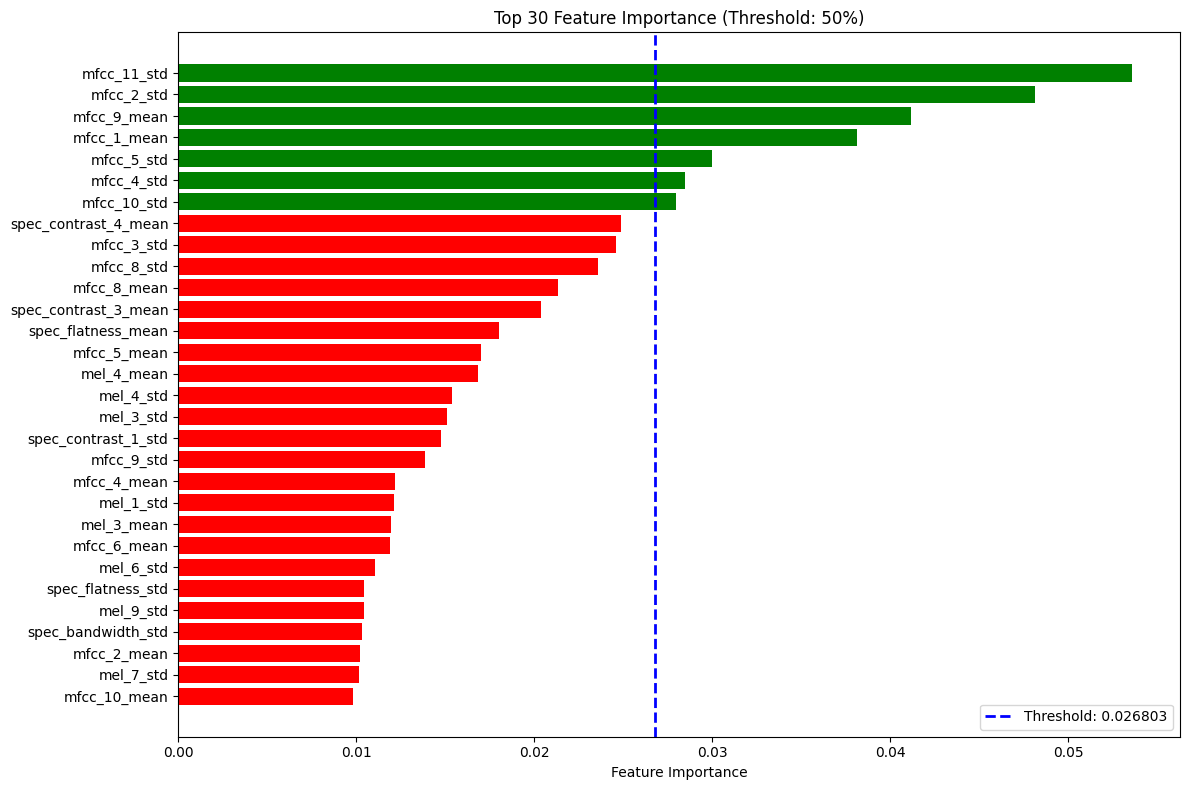


ANALISIS PER KATEGORI FITUR
   Category  Total_Features  Selected_Features  Selection_Rate  Avg_Importance
Statistical              13                  0          0.0000          0.0033
   Temporal               8                  0          0.0000          0.0036
   Spectral              24                  0          0.0000          0.0076
       MFCC              26                  7         26.9231          0.0179
     Chroma              24                  0          0.0000          0.0024
        Mel              20                  0          0.0000          0.0091
    Tonnetz              12                  0          0.0000          0.0037


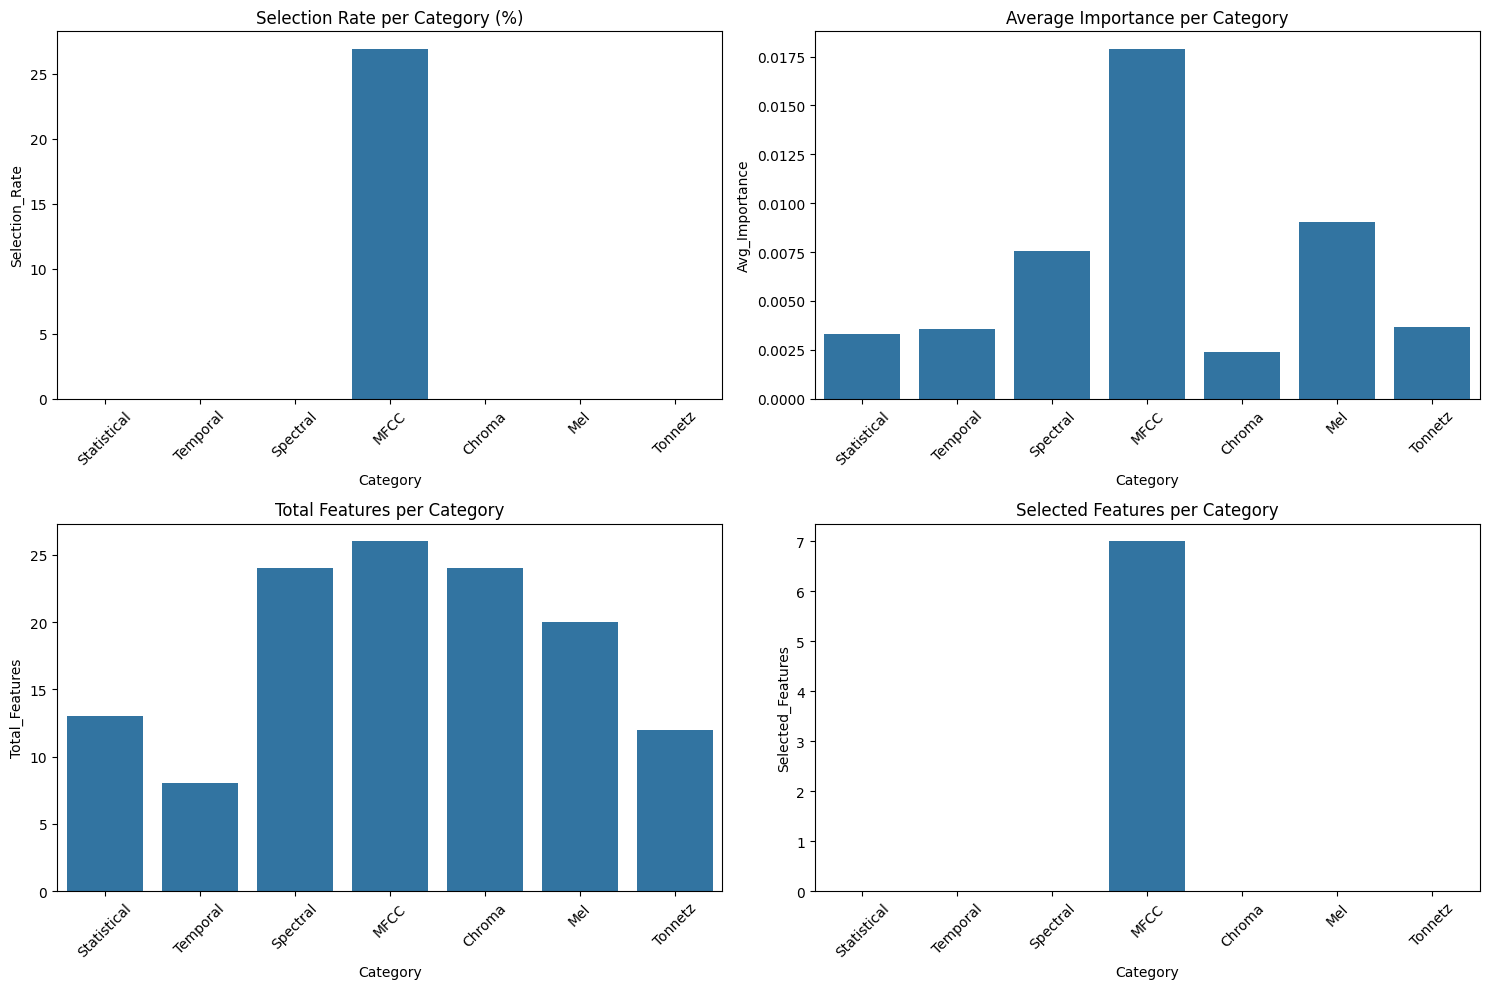


MENYIMPAN DATASET TERPILIH
Shape train terpilih: (160, 8)
Shape val terpilih: (40, 8)

Files saved: train_features_selected.csv, val_features_selected.csv


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def feature_importance_analysis(train_df, val_df, importance_threshold=50):
    # Pastikan kolom 'label' ada
    if 'label' not in train_df.columns or 'label' not in val_df.columns:
        raise ValueError("Dataframe harus memiliki kolom 'label'.")

    # Buang kolom non-fiturnya (metadata) jika ada
    meta_cols = ['label', 'speaker', 'action', 'filename']
    feature_cols = [c for c in train_df.columns if c not in meta_cols]

    if len(feature_cols) == 0:
        raise ValueError("Tidak ada kolom fitur ditemukan di train_df setelah menghapus metadata.")

    # Pisahkan fitur dan label
    X_train = train_df[feature_cols].copy()
    y_train = train_df['label'].copy()
    X_val   = val_df[feature_cols].copy()
    y_val   = val_df['label'].copy()
    
    # Train Random Forest untuk mendapatkan feature importance
    print("Training Random Forest untuk analisis feature importance...")
    rf_temp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train.fillna(0), y_train)  # isi NaN dengan 0 jika ada
    
    # Dapatkan feature importance
    importances = pd.Series(rf_temp.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # Hitung threshold berdasarkan persentase dari importance maksimum
    max_importance = importances.max()
    absolute_threshold = max_importance * (importance_threshold / 100)
    
    # Fitur yang lolos threshold
    selected_features = importances[importances >= absolute_threshold].index.tolist()
    removed_features = importances[importances < absolute_threshold].index.tolist()
    
    print(f"\nHASIL ANALISIS FEATURE IMPORTANCE")
    print(f"{'='*50}")
    print(f"Total fitur awal: {len(importances)}")
    print(f"Threshold: {importance_threshold}% dari importance maksimum")
    print(f"Absolute threshold: {absolute_threshold:.6f}")
    print(f"Fitur yang dipilih: {len(selected_features)}")
    print(f"Fitur yang dihapus: {len(removed_features)}")
    
    # Visualisasi feature importance (top 30)
    plt.figure(figsize=(12, 8))
    colors = ['green' if imp >= absolute_threshold else 'red' for imp in importances.values]
    top_features = importances.head(30)
    top_colors = colors[:30]
    plt.barh(range(len(top_features)), top_features.values, color=top_colors)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Feature Importance')
    plt.title(f'Top 30 Feature Importance (Threshold: {importance_threshold}%)')
    plt.axvline(x=absolute_threshold, color='blue', linestyle='--', linewidth=2, label=f'Threshold: {absolute_threshold:.6f}')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Analisis per kategori fitur
    feature_categories = {
        'Statistical': [f for f in importances.index if f.startswith('stat_')],
        'Temporal': [f for f in importances.index if f.startswith('temp_')],
        'Spectral': [f for f in importances.index if f.startswith('spec_')],
        'MFCC': [f for f in importances.index if f.startswith('mfcc_')],
        'Chroma': [f for f in importances.index if f.startswith('chroma_')],
        'Mel': [f for f in importances.index if f.startswith('mel_')],
        'Tonnetz': [f for f in importances.index if f.startswith('tonnetz_')]
    }
    
    category_analysis = []
    for category, features in feature_categories.items():
        category_features = [f for f in features if f in importances.index]
        if category_features:
            selected_in_category = [f for f in category_features if f in selected_features]
            avg_importance = importances[category_features].mean() if len(category_features)>0 else 0.0
            category_analysis.append({
                'Category': category,
                'Total_Features': len(category_features),
                'Selected_Features': len(selected_in_category),
                'Selection_Rate': (len(selected_in_category) / len(category_features) * 100) if len(category_features)>0 else 0.0,
                'Avg_Importance': avg_importance
            })
    
    category_df = pd.DataFrame(category_analysis)
    
    print(f"\nANALISIS PER KATEGORI FITUR")
    print(f"{'='*50}")
    if not category_df.empty:
        print(category_df.to_string(index=False, float_format='%.4f'))
    else:
        print("Tidak ada kategori fitur yang ditemukan.")
    
    # Visualisasi per kategori (jika ada)
    if not category_df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        sns.barplot(data=category_df, x='Category', y='Selection_Rate', ax=axes[0,0])
        axes[0,0].set_title('Selection Rate per Category (%)')
        axes[0,0].tick_params(axis='x', rotation=45)

        sns.barplot(data=category_df, x='Category', y='Avg_Importance', ax=axes[0,1])
        axes[0,1].set_title('Average Importance per Category')
        axes[0,1].tick_params(axis='x', rotation=45)

        sns.barplot(data=category_df, x='Category', y='Total_Features', ax=axes[1,0])
        axes[1,0].set_title('Total Features per Category')
        axes[1,0].tick_params(axis='x', rotation=45)

        sns.barplot(data=category_df, x='Category', y='Selected_Features', ax=axes[1,1])
        axes[1,1].set_title('Selected Features per Category')
        axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
    
    # Buat dataset dengan fitur terpilih (jika selected_features kosong, kembalikan original X + label)
    if len(selected_features) == 0:
        print("\nPeringatan: Tidak ada fitur yang melewati threshold. Mengembalikan dataset awal.")
        X_train_selected = X_train.copy()
        X_val_selected = X_val.copy()
    else:
        X_train_selected = X_train[selected_features].copy()
        X_val_selected = X_val[selected_features].copy()
    
    train_selected = X_train_selected.copy()
    train_selected['label'] = y_train.values
    val_selected = X_val_selected.copy()
    val_selected['label'] = y_val.values
    
    print(f"\nMENYIMPAN DATASET TERPILIH")
    print(f"{'='*50}")
    print(f"Shape train terpilih: {train_selected.shape}")
    print(f"Shape val terpilih: {val_selected.shape}")
    
    return train_selected, val_selected, selected_features, removed_features, importances

# ---- Jalankan analisis feature importance sesuai request ----
train_selected, val_selected, selected_features, removed_features, feature_importances = feature_importance_analysis(
    train_features_full, val_features_full, importance_threshold=50
)

# Simpan hasil
train_selected.to_csv("train_features_selected.csv", index=False)
val_selected.to_csv("val_features_selected.csv", index=False)
print("\nFiles saved: train_features_selected.csv, val_features_selected.csv")


5. Detail Analysis

In [20]:
import json

def _feature_category(feature_name):
    if feature_name.startswith('stat_'):
        return 'Statistical'
    elif feature_name.startswith('temp_'):
        return 'Temporal'
    elif feature_name.startswith('spec_'):
        return 'Spectral'
    elif feature_name.startswith('mfcc_'):
        return 'MFCC'
    elif feature_name.startswith('chroma_'):
        return 'Chroma'
    elif feature_name.startswith('mel_'):
        return 'Mel'
    elif feature_name.startswith('tonnetz_'):
        return 'Tonnetz'
    else:
        return 'Other'

def detailed_feature_analysis(selected_features, removed_features, feature_importances, threshold_used=50):
    """
    Analisis detail fitur yang dipilih dan yang dihapus.
    feature_importances diharapkan pd.Series atau dict-like {feature: importance}
    """
    # pastikan feature_importances bisa diakses seperti dict
    if hasattr(feature_importances, "to_dict"):
        fi_dict = feature_importances.to_dict()
    else:
        fi_dict = dict(feature_importances)

    print(f"\nDETAIL FITUR TERPILIH")
    print(f"{'='*70}")
    print(f"{'Fitur':<30} {'Importance':<15} {'Kategori':<15}")
    print(f"{'-'*70}")
    
    for feature in selected_features:
        importance = fi_dict.get(feature, 0.0)
        category = _feature_category(feature)
        print(f"{feature:<30} {importance:<15.6f} {category:<15}")
    
    print(f"\nFITUR YANG DIHAPUS (Top 10)")
    print(f"{'='*70}")
    print(f"{'Fitur':<30} {'Importance':<15} {'Kategori':<15}")
    print(f"{'-'*70}")
    
    # ambil importance untuk removed_features, sortir descending dan ambil top 10
    removed_with_imp = [(f, fi_dict.get(f, 0.0)) for f in removed_features]
    removed_sorted = sorted(removed_with_imp, key=lambda x: x[1], reverse=True)[:10]
    
    for feature, importance in removed_sorted:
        category = _feature_category(feature)
        print(f"{feature:<30} {importance:<15.6f} {category:<15}")

# Jalankan analisis detail (menggunakan variabel yang sudah ada di namespace)
detailed_feature_analysis(selected_features, removed_features, feature_importances, threshold_used=50)

# Simpan info ringkasan ke JSON
feature_info = {
    'selected_features': list(selected_features),
    'removed_features': list(removed_features),
    'feature_importances': {k: float(v) for k, v in (feature_importances.to_dict().items() if hasattr(feature_importances, "to_dict") else feature_importances.items())},
    'threshold_used': 50,
    'total_original_features': len(feature_importances),
    'total_selected_features': len(selected_features),
    'total_removed_features': len(removed_features)
}

with open('feature_selection_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"\nInformasi feature selection disimpan ke: feature_selection_info.json")



DETAIL FITUR TERPILIH
Fitur                          Importance      Kategori       
----------------------------------------------------------------------
mfcc_11_std                    0.053605        MFCC           
mfcc_2_std                     0.048116        MFCC           
mfcc_9_mean                    0.041195        MFCC           
mfcc_1_mean                    0.038149        MFCC           
mfcc_5_std                     0.029991        MFCC           
mfcc_4_std                     0.028459        MFCC           
mfcc_10_std                    0.027964        MFCC           

FITUR YANG DIHAPUS (Top 10)
Fitur                          Importance      Kategori       
----------------------------------------------------------------------
spec_contrast_4_mean           0.024859        Spectral       
mfcc_3_std                     0.024608        MFCC           
mfcc_8_std                     0.023554        MFCC           
mfcc_8_mean                    0.021348        MFC

6. Outlier Detection & Handling

In [24]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_outliers_multiple_methods(df, contamination=0.1):
    """
    Mendeteksi outlier menggunakan:
      1. IQR Method
      2. Z-Score Method
      3. Isolation Forest
    Return:
      dictionary berisi mask outlier & X_scaled
    """
    X = df.drop(columns=['label'])
    labels = df['label']
    
    # ------------------------------
    # METHOD 1: IQR
    # ------------------------------
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    
    # ------------------------------
    # METHOD 2: Z-SCORE (|z| > 3)
    # ------------------------------
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    outlier_mask_zscore = (np.abs(X_scaled) > 3).any(axis=1)
    
    # ------------------------------
    # METHOD 3: Isolation Forest
    # ------------------------------
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outlier_mask_iso = iso_forest.fit_predict(X_scaled) == -1
    
    return {
        'iqr_outliers': outlier_mask_iqr,
        'zscore_outliers': outlier_mask_zscore,
        'isolation_outliers': outlier_mask_iso,
        'X_scaled': X_scaled
    }


def analyze_outliers(train_df, val_df, contamination=0.1):
    """
    Analisis outlier pada training dan validation:
      - Hitung jumlah outlier
      - Visualisasi outlier per kelas tanpa boxplot (barplot)
    Output sama dengan kode versi kamu.
    """
    
    print("ANALISIS OUTLIER")
    print("="*50)
    
    # Deteksi outlier di training set dan validation set
    train_outliers = detect_outliers_multiple_methods(train_df, contamination)
    val_outliers = detect_outliers_multiple_methods(val_df, contamination)
    
    # Hitung statistik outlier
    train_iqr_count = train_outliers['iqr_outliers'].sum()
    train_zscore_count = train_outliers['zscore_outliers'].sum()
    train_iso_count = train_outliers['isolation_outliers'].sum()
    
    val_iqr_count = val_outliers['iqr_outliers'].sum()
    val_zscore_count = val_outliers['zscore_outliers'].sum()
    val_iso_count = val_outliers['isolation_outliers'].sum()
    
    # ------------------------------ PRINT OUTPUT ------------------------------
    print(f"TRAINING SET ({len(train_df)} samples):")
    print(f"  IQR Method: {train_iqr_count} outliers ({train_iqr_count/len(train_df)*100:.1f}%)")
    print(f"  Z-Score Method: {train_zscore_count} outliers ({train_zscore_count/len(train_df)*100:.1f}%)")
    print(f"  Isolation Forest: {train_iso_count} outliers ({train_iso_count/len(train_df)*100:.1f}%)")
    
    print(f"\nVALIDATION SET ({len(val_df)} samples):")
    print(f"  IQR Method: {val_iqr_count} outliers ({val_iqr_count/len(val_df)*100:.1f}%)")
    print(f"  Z-Score Method: {val_zscore_count} outliers ({val_zscore_count/len(val_df)*100:.1f}%)")
    print(f"  Isolation Forest: {val_iso_count} outliers ({val_iso_count/len(val_df)*100:.1f}%)")
    
    # ------------------------------ VISUALISASI ------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Training outliers by class
    train_outlier_by_class = train_df.groupby('label').apply(
        lambda x: pd.Series({
            'IQR': detect_outliers_multiple_methods(x)['iqr_outliers'].sum(),
            'Z-Score': detect_outliers_multiple_methods(x)['zscore_outliers'].sum(),
            'Isolation': detect_outliers_multiple_methods(x)['isolation_outliers'].sum()
        })
    ).reset_index()
    
    train_outlier_melted = pd.melt(train_outlier_by_class, id_vars=['label'], 
                                   var_name='Method', value_name='Count')
    
    sns.barplot(data=train_outlier_melted, x='label', y='Count', hue='Method', ax=axes[0])
    axes[0].set_title('Training Set: Outliers by Class & Method')
    
    # Validation outliers by class
    val_outlier_by_class = val_df.groupby('label').apply(
        lambda x: pd.Series({
            'IQR': detect_outliers_multiple_methods(x)['iqr_outliers'].sum(),
            'Z-Score': detect_outliers_multiple_methods(x)['zscore_outliers'].sum(),
            'Isolation': detect_outliers_multiple_methods(x)['isolation_outliers'].sum()
        })
    ).reset_index()
    
    val_outlier_melted = pd.melt(val_outlier_by_class, id_vars=['label'], 
                                  var_name='Method', value_name='Count')
    
    sns.barplot(data=val_outlier_melted, x='label', y='Count', hue='Method', ax=axes[1])
    axes[1].set_title('Validation Set: Outliers by Class & Method')
    
    plt.tight_layout()
    plt.show()
    
    return train_outliers, val_outliers


In [26]:
def remove_outliers_consensus(df, outlier_results, min_methods=2):
    """
    Menghapus outlier berdasarkan konsensus dari 3 metode:
      - IQR
      - Z-Score
      - Isolation Forest
    Outlier dihapus jika terdeteksi oleh >= min_methods.
    Output sama persis dengan kode versi kamu.
    """

    # Hitung total metode yang mendeteksi outlier per sample
    outlier_counts = (
        outlier_results['iqr_outliers'].astype(int) + 
        outlier_results['zscore_outliers'].astype(int) + 
        outlier_results['isolation_outliers'].astype(int)
    )
    
    # Mask consensus
    consensus_outliers = outlier_counts >= min_methods
    
    # Pisahkan data
    clean_df = df[~consensus_outliers].copy()
    removed_df = df[consensus_outliers].copy()
    
    # ------------------------------ PRINT OUTPUT ------------------------------
    print(f"Outlier removal dengan consensus:")
    print(f"  Original samples: {len(df)}")
    print(f"  Outliers removed: {len(removed_df)} ({len(removed_df)/len(df)*100:.1f}%)")
    print(f"  Clean samples: {len(clean_df)} ({len(clean_df)/len(df)*100:.1f}%)")
    
    # Distribusi kelas
    original_dist = df['label'].value_counts()
    clean_dist = clean_df['label'].value_counts()
    removed_dist = removed_df['label'].value_counts() if len(removed_df) > 0 else pd.Series(dtype=int)
    
    print("\nDistribusi kelas:")
    print(f"  Original: {dict(original_dist)}")
    print(f"  Clean: {dict(clean_dist)}")
    if len(removed_dist) > 0:
        print(f"  Removed: {dict(removed_dist)}")
    
    return clean_df, removed_df


ANALISIS OUTLIER
TRAINING SET (160 samples):
  IQR Method: 7 outliers (4.4%)
  Z-Score Method: 1 outliers (0.6%)
  Isolation Forest: 16 outliers (10.0%)

VALIDATION SET (40 samples):
  IQR Method: 11 outliers (27.5%)
  Z-Score Method: 0 outliers (0.0%)
  Isolation Forest: 4 outliers (10.0%)


/tmp/ipykernel_25983/476795135.py:84: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_outlier_by_class = train_df.groupby('label').apply(
/tmp/ipykernel_25983/476795135.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_outlier_by_class = val_df.groupby('label').apply(


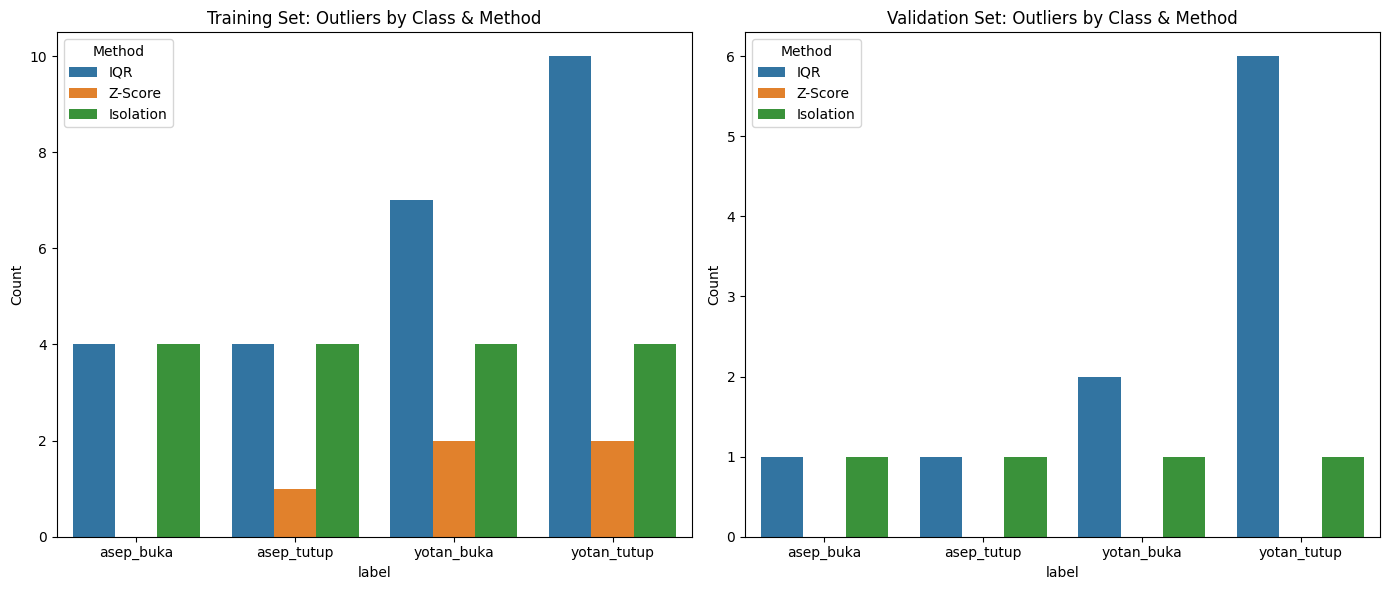

Outlier removal dengan consensus:
  Original samples: 160
  Outliers removed: 4 (2.5%)
  Clean samples: 156 (97.5%)

Distribusi kelas:
  Original: {'asep_tutup': np.int64(40), 'yotan_tutup': np.int64(40), 'asep_buka': np.int64(40), 'yotan_buka': np.int64(40)}
  Clean: {'asep_tutup': np.int64(40), 'yotan_tutup': np.int64(40), 'asep_buka': np.int64(40), 'yotan_buka': np.int64(36)}
  Removed: {'yotan_buka': np.int64(4)}
Outlier removal dengan consensus:
  Original samples: 40
  Outliers removed: 2 (5.0%)
  Clean samples: 38 (95.0%)

Distribusi kelas:
  Original: {'asep_buka': np.int64(10), 'yotan_buka': np.int64(10), 'asep_tutup': np.int64(10), 'yotan_tutup': np.int64(10)}
  Clean: {'asep_buka': np.int64(10), 'asep_tutup': np.int64(10), 'yotan_tutup': np.int64(10), 'yotan_buka': np.int64(8)}
  Removed: {'yotan_buka': np.int64(2)}

Dataset clean disimpan:
   train_features_clean.csv: (156, 8)
   val_features_clean.csv: (38, 8)
   train_outliers_removed.csv: (4, 8)
   val_outliers_removed.c

In [27]:
# Pastikan import yang dibutuhkan ada
import pandas as pd

# Jalankan analisis outlier (menggunakan fungsi analyze_outliers yang sudah didefinisikan)
train_outliers, val_outliers = analyze_outliers(train_selected, val_selected, contamination=0.1)

# Hapus outlier dengan consensus (>= 2 metode)
train_clean, train_removed = remove_outliers_consensus(train_selected, train_outliers, min_methods=2)
val_clean, val_removed     = remove_outliers_consensus(val_selected, val_outliers, min_methods=2)

# Simpan dataset clean dan yang dihapus ke CSV
train_clean.to_csv("train_features_clean.csv", index=False)
val_clean.to_csv("val_features_clean.csv", index=False)
train_removed.to_csv("train_outliers_removed.csv", index=False)
val_removed.to_csv("val_outliers_removed.csv", index=False)

# Print ringkasan hasil (format sama persis seperti yang kamu contohkan)
print(f"\nDataset clean disimpan:")
print(f"   train_features_clean.csv: {train_clean.shape}")
print(f"   val_features_clean.csv: {val_clean.shape}")
print(f"   train_outliers_removed.csv: {train_removed.shape}")
print(f"   val_outliers_removed.csv: {val_removed.shape}")
